# Filters
A notebook to test filter implementation for ease of converting to `C`, `C++`, or `ino` for the Arduino.

## Initial setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Real-time peak detection (with drifting baseline)

### Create noisy signal
A quick explanation of the signal-to-noise ratio (SNR). The power for any waveform $y(t)$ over the interval $[0, T)$ is given by:

$
\quad P_y = \frac{1}{T} \int_0^T y^2(t) dt
$

The SNR is defined as the ratio of the signal ($s(t)$) power to the noise $N(t)$ power. If we assume that, over a given interval $[0, T)$:

- The signal is constant (non-random); that is, $s(t) = k \forall t \in [0, T)$.
- The noise is distributed as $\mathcal{N} (0, \sigma_N^2)$.

then the SNR becomes:

$
\begin{align}
\quad P_s 
&= \frac{1}{T} \int_0^T s^2(t) dt \\
&= \frac{1}{T} \int_0^T k^2 dt \\
&= \frac{1}{T} k^2 \int_0^T dt \\
&= \frac{1}{T} k^2 T \\
&= k^2
\end{align}
$

$
\begin{align}
\quad P_N 
&= \frac{1}{T} \int_0^T N^2(t) dt \\
&= \frac{1}{T} \int_0^T \left ( N(t) - 0 \right )^2 dt \\
&= \frac{1}{T} \int_0^T \left ( N(t) - \mathbb{E} \left [ N(t) \right ] \right )^2 dt \\
&= \sigma_N^2
\end{align}
$

$
\quad SNR = \dfrac{P_s}{P_N} = \dfrac{k^2}{\sigma_N^2}
$

or expressed in decibels:

$
\quad SNR_{dB} = 10 log_{10} \left ( \dfrac{P_s}{P_N} \right ) = 10 log_{10} \left ( \dfrac{k^2}{\sigma_N^2} \right )
$

[See here](http://www.scholarpedia.org/article/Signal-to-noise_ratio) for more details.

In [27]:
# Raw signal
T = 1000
y = np.zeros(T)

# Add noise (assume N(0, sigma_N))
sigma_N = 1.0
y += np.random.normal(loc=0.0, scale=sigma_N, size=T)

# Add peaks (assume N(SNR, 0))
SNR = 20.0 # dB
dt_signal = 5
n_signal = 10
t_signal = np.random.randint(int(0.10*T), int(min(0.9*T, T-dt_signal)), size=n_signal)
t_signal = (t_signal[:, np.newaxis] + (np.arange(dt_signal)+1)[np.newaxis, :]).flatten()
y[t_signal] += ((sigma_N**2)*(10**(SNR/10.0)))**0.5 # k = (sigma_N^2 10^(SNR_dB/10))^0.5

# Add constant drift
drift_slope = 0.01
y += np.arange(T)*drift_slope

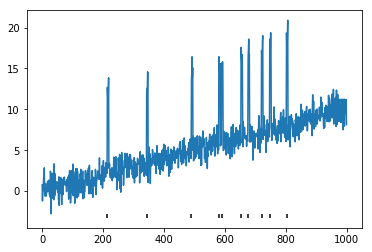

In [28]:
# Plot noisy signal
plt.plot(y)
plt.vlines(t_signal[::dt_signal], ymin=np.min(y)-0.5, ymax=np.min(y))

### Apply real-time filter
Since we are mimicking real-time, we will feed values one at a time. We will also keep in mind that we need to adapt this code to `C`, so we can't get too fancy with indexing or higher-level structures, nor do we want to store any data beyond the buffer size (in the actual implementation). 

Credit: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data

In [29]:
# Filter settings
n_filt = 50 # length of filter
thresh = 3.0 # number of stds from mean
alpha = 0.5 # influence of datapoint containing signal on buffer

# Initialize buffers
buffer = y[:n_filt]
buffer_mean = np.mean(buffer)
buffer_std = np.std(buffer)
p = 0 # buffer pointer

# Placeholder (for dev purposes)
y_filt = np.zeros(T) # moving average
y_filt[:n_filt] = buffer_mean
x = np.zeros(T) # signal

# Feed data stream
for t in range(n_filt, T):
    # Check if signal threshold passed
    if abs(y[t] - buffer_mean) > thresh*buffer_std:
        # Update signal array
        if (y[t] - buffer_mean) > 0: # positive signal
            x[t] = 1.0
        else: # negative signal
            x[t] = -1.0
            
        # Update buffer
        buffer[p] = alpha*y[t] + (1.0 - alpha)*y[t-1]
    else:
        x[t] = 0.0
        buffer[p] = y[t]
    
    # Update filtered data stream (dev)
    y_filt[t] = buffer[p]
    
    # Update buffer stats
    buffer_mean = np.mean(buffer)
    buffer_std = np.std(buffer)
    p = (p + 1) % n_filt

true positive rate:  0.74 (37 of 50)
false positive rate: 0.00 (1 of 950)


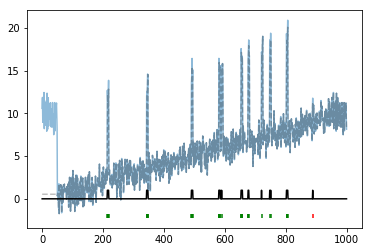

In [30]:
# Plot results
plt.plot(y, color='C0', alpha=0.5, linestyle='-')
plt.plot(x, color='black', alpha=1.0, linestyle='-')
plt.plot(y_filt, color='black', alpha=0.25, linestyle='--')

# Plot ground truth
idx_gt = np.zeros(T, dtype=np.bool)
idx_gt[t_signal] = True
idx_tp = np.logical_and(x == 1.0, idx_gt)
idx_fp = np.logical_and(np.abs(x) == 1.0, ~idx_gt)
plt.vlines(np.argwhere(idx_tp).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), color='green')
plt.vlines(np.argwhere(idx_fp).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), color='red')

# Print results
print('true positive rate:  %.2f (%d of %d)' % (np.sum(idx_tp)/(n_signal*dt_signal), np.sum(idx_tp), n_signal*dt_signal))
print('false positive rate: %.2f (%d of %d)' % (np.sum(idx_fp)/(T - n_signal*dt_signal), np.sum(idx_fp), T - n_signal*dt_signal))